# Energy-Based models and structured prediction

In this project we're going to work with structured prediction. 

We're going to work with text. The task is to transcribe a word from an image. The difficulty here is that different words have different lengths, so we can't just have fixed number of outputs.

Furthermore, we will be comparing model trained with our DP solution to model trained with GTN framework.

# GTN Framework

GTN framework has support for finding Viterbi paths and training the prediction
- [CTC](https://distill.pub/2017/ctc/)
- [Weighted Automata in ML](https://awnihannun.com/writing/automata_ml/automata_in_machine_learning.pdf)

Additional Links\:
- [GTN Documentation](https://gtn.readthedocs.io/en/latest/)
- [GTN Applications](https://github.com/facebookresearch/gtn_applications)

## Dataset
As always, the first thing to do is implementing the dataset. We're going to create a dataset that creates images of random words. We'll also include some augmentations, such as jitter (moving the character horizontally).

In [1]:
! mkdir fonts
! curl --output fonts/font.zip https://www.fontsquirrel.com/fonts/download/Anonymous
! unzip -n fonts/font.zip -d fonts

mkdir: cannot create directory ‘fonts’: File exists
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29805  100 29805    0     0  30006      0 --:--:-- --:--:-- --:--:-- 29984
Archive:  fonts/font.zip


torch.Size([32, 18])
image for: p


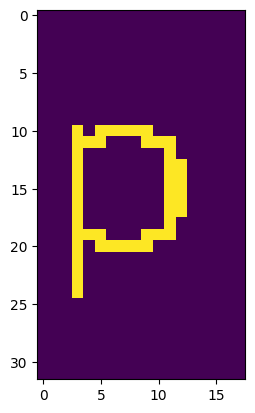

In [ ]:
from PIL import ImageDraw, ImageFont
import string
import random
import torch
import torchvision
from torchvision import transforms
from PIL import Image 
from matplotlib import pyplot as plt

simple_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                ])

class SimpleWordsDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_length, len=100, jitter=False, noise=False):
    self.max_length = max_length
    self.transforms = transforms.ToTensor()
    self.len = len
    self.jitter = jitter
    self.noise = noise

  def __len__(self):
    return self.len

  def __iter__(self):
    for _ in range(self.len):
        text = ''.join([random.choice(string.ascii_lowercase) for i in range(self.max_length)])
        img = self.draw_text(text, jitter=self.jitter, noise=self.noise)
        yield img, text

  def draw_text(self, text, length=None, jitter=False, noise=False):
    if length == None:
        length = 18 * len(text)
    img = Image.new('L', (length, 32))
    fnt = ImageFont.truetype("fonts/Anonymous.ttf", 20)

    d = ImageDraw.Draw(img)
    pos = (0, 5)
    if jitter:
        pos = (random.randint(0, 7), 5)
    else:
        pos = (0, 5)
    d.text(pos, text, fill=1, font=fnt)

    img = self.transforms(img)
    img[img > 0] = 1

    if noise:
        img += torch.bernoulli(torch.ones_like(img) * 0.1)
        img = img.clamp(0, 1)


    return img[0]

sds = SimpleWordsDataset(1, jitter=True, noise=False)
img, text = next(iter(sds))
print(img.shape)
plt.imshow(img)
print(f'image for: {text}')

We can look at what the entire alphabet looks like in this dataset.

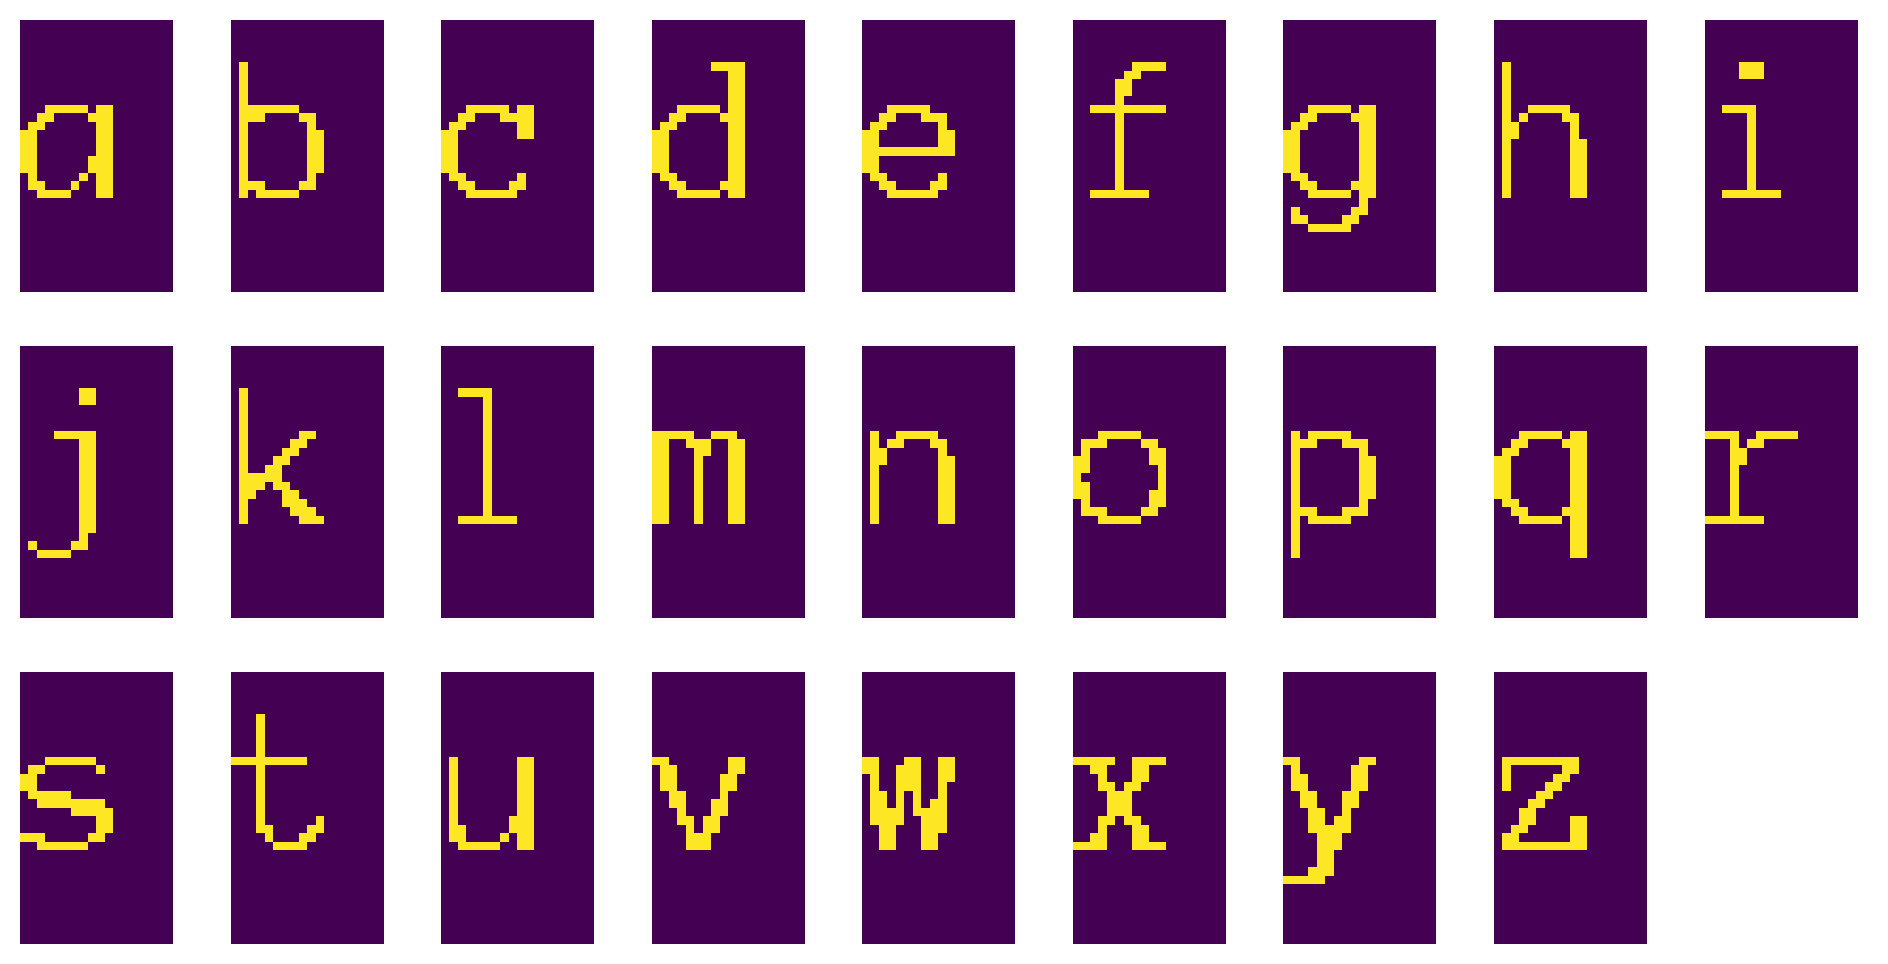

In [3]:
fig, ax = plt.subplots(3, 9, figsize=(12, 6), dpi=200)

for i, c in enumerate(string.ascii_lowercase):
    row = i // 9
    col = i % 9
    ax[row][col].imshow(sds.draw_text(c))
    ax[row][col].axis('off')
ax[2][8].axis('off')

plt.show()

We can also put the entire alphabet in one image.

(np.float64(-0.5), np.float64(339.5), np.float64(31.5), np.float64(-0.5))

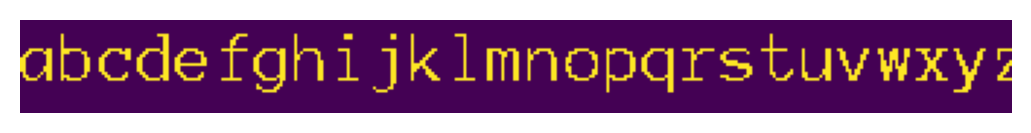

In [4]:
alphabet = sds.draw_text(string.ascii_lowercase, 340)
plt.figure(dpi=200)
plt.imshow(alphabet)
plt.axis('off')

## Model definition
Before we define the model, we define the size of our alphabet. Our alphabet consists of lowercase English letters, and additionally a special character used for space between symbols or before and after the word. For the first part of this assignment, we don't need that extra character.

Our end goal is to learn to transcribe words of arbitrary length. However, first, we pre-train our simple convolutional neural net to recognize single characters. In order to be able to use the same model for one character and for entire words, we are going to design the model in a way that makes sure that the output size for one character (or when input image size is 32x18) is 1x27, and Kx27 whenever the input image is wider. K here will depend on particular architecture of the network, and is affected by strides, poolings, among other things.
A little bit more formally, our model $f_\theta$, for an input image $x$ gives output energies $l = f_\theta(x)$. If $x \in \mathbb{R}^{32 \times 18}$, then $l \in \mathbb{R}^{1 \times 27}$.
If $x \in \mathbb{R}^{32 \times 100}$ for example, our model may output $l \in \mathbb{R}^{10 \times 27}$, where $l_i$ corresponds to a particular window in $x$, for example from $x_{0, 9i}$ to $x_{32, 9i + 18}$ (again, this will depend on the particular architecture).

Below is a drawing that explains the sliding window concept. We use the same neural net with the same weights to get $l_1, l_2, l_3$, the only difference is receptive field. $l_1$ is looks at the leftmost part, at character 'c', $l_2$ looks at 'a', and $l_3$ looks at 't'. The receptive field may or may not overlap, depending on how you design your convolutions.

![cat.png](https://i.imgur.com/JByfyKh.png)

In [5]:
# constants for number of classes in total, and for the special extra character for empty space
ALPHABET_SIZE = 27
BETWEEN = 26

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16,
                               kernel_size=3, stride=(2,1), padding=1)

        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=3, stride=(2,1), padding=1)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, stride=(2,1), padding=1)

        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, stride=(2,1), padding=1)

        self.conv_5 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=3, stride=(2,1), padding=1)

        self.conv_6 = nn.Conv2d(in_channels=128, out_channels=ALPHABET_SIZE,
                                    kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(ALPHABET_SIZE)

    def forward(self, x):
        """
        Input x: (bs, 1, 32, k)
        after applying cnn_block, x.shape should be: (bs, alphabet_size, 1, width)
        """

        x = self.conv_1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv_4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.conv_5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv_6(x)
        # x = self.bn6(x)
        x = x.squeeze(2)

        return x

Let's initalize the model and apply it to the alphabet image:

In [7]:
model = SimpleNet()

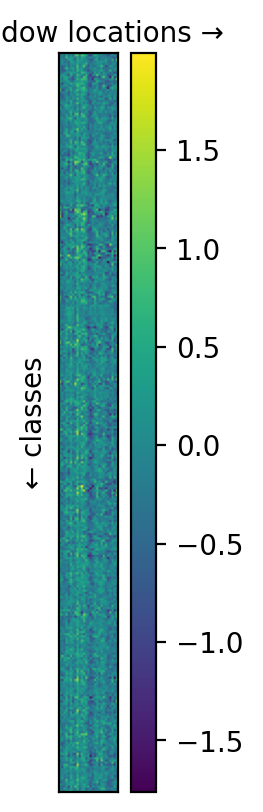

In [8]:
alphabet_energies = model(alphabet.view(1, 1, *alphabet.shape))

def plot_energies(ce):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    #reshape for matplotlib reqs
    im = ax.imshow(ce.cpu().numpy().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← classes')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

plot_energies(alphabet_energies[0].detach())

So far we only see random outputs, because the classifier is untrained.

## Train with one character

Now we train the model we've created on a dataset where images contain only single characters. Note the changed cross_entropy function.

In [ ]:
def train_model(model, epochs, dataloader, criterion, optimizer):

    model.train()
    for epoch in range(epochs):
        tot_loss = 0.0

        for images, labels in dataloader:
            optimizer.zero_grad()

            images = images.cuda()  # Move images to CUDA
            labels = labels.cuda()  # Move labels to CUDA

            # forward pass
            energies = model(images)

            energies = energies.mean(-1)

            # get loss
            loss = criterion(energies, labels.long())

            # backprop
            loss.backward()
            optimizer.step()

            tot_loss += loss.item()

        avg_loss = tot_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

def cross_entropy(energies, *args, **kwargs):
    """ We use energies, and therefore we need to use log soft arg min instead
        of log soft arg max. To do that we just multiply energies by -1. """
    return nn.functional.cross_entropy(-1 * energies, *args, **kwargs)

def simple_collate_fn(samples):
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(lambda c : torch.tensor(ord(c) - ord('a')), annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))

    images = [img.unsqueeze(0) for img in images]

    if len(images) == 1:
        return images[0].unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack(images), torch.stack(annotations)

sds = SimpleWordsDataset(1, len=1000, jitter=True, noise=False)
dataloader = torch.utils.data.DataLoader(sds, batch_size=16, num_workers=0, collate_fn=simple_collate_fn)

model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_model(model, epochs=25, dataloader=dataloader, criterion=cross_entropy, optimizer=optimizer)





Epoch 1/25, Loss: 1.3060
Epoch 2/25, Loss: 0.1748
Epoch 3/25, Loss: 0.0586
Epoch 4/25, Loss: 0.0318
Epoch 5/25, Loss: 0.0203
Epoch 6/25, Loss: 0.0158
Epoch 7/25, Loss: 0.0100
Epoch 8/25, Loss: 0.0073
Epoch 9/25, Loss: 0.0059
Epoch 10/25, Loss: 0.0044
Epoch 11/25, Loss: 0.0044
Epoch 12/25, Loss: 0.0036
Epoch 13/25, Loss: 0.0030
Epoch 14/25, Loss: 0.0027
Epoch 15/25, Loss: 0.0025
Epoch 16/25, Loss: 0.0021
Epoch 17/25, Loss: 0.0019
Epoch 18/25, Loss: 0.0017
Epoch 19/25, Loss: 0.0016
Epoch 20/25, Loss: 0.0016
Epoch 21/25, Loss: 0.0014
Epoch 22/25, Loss: 0.0012
Epoch 23/25, Loss: 0.0012
Epoch 24/25, Loss: 0.0010
Epoch 25/25, Loss: 0.0008


In [11]:
def get_accuracy(model, dataset):
    model.eval()
    cnt = 0
    for image, label in dataset:
        image = image.unsqueeze(0).unsqueeze(0).cuda()
        energies = model(image)
        energies = energies[0]
        energies = energies.mean(dim=-1)
        pred_class = energies.argmin(dim=0).item()
        true_class = ord(label[0]) - ord('a')
        cnt += int(pred_class == true_class)

    return cnt / len(dataset)

tds = SimpleWordsDataset(1, len=100)
accuracy = get_accuracy(model, tds)
print(f'accuracy: {accuracy}')
assert accuracy == 1.0, 'Your model doesn\'t achieve near perfect accuracy for 1 character'

accuracy: 1.0


Now, to see how our model would work with more than one character, we apply the model to a bigger input - the image of the alphabet we saw earlier. We extract the energies for each window and show them.

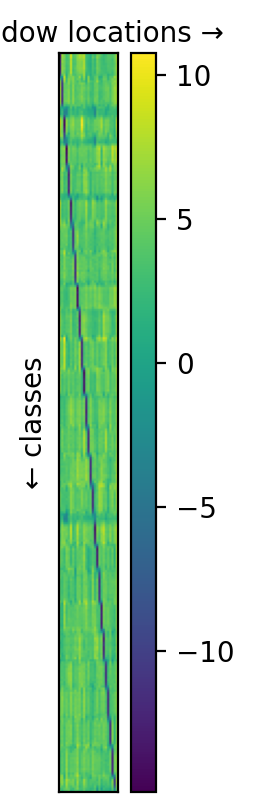

In [12]:
alphabet_energies_post_train = model(alphabet.cuda().view(1, 1, *alphabet.shape))
plot_energies(alphabet_energies_post_train[0].detach())

## Training with multiple characters

Now, we want to train our model to not only recognize the letters, but also to recognize space in-between so that we can use it for transcription later.

This is where complications begin. When transcribing a word from an image, we don't know beforehand how long the word is going to be. We can use our convolutional neural network we've pretrained on single characters to get prediction of character probabilities for all the positions of an input window in the new input image, but we don't know beforehand how to match those predictions with the target label. Training with incorrect matching can lead to wrong model, so in order to be able to train a network to transcribe words, we need a way to find these pairings.

![dl.png](https://i.imgur.com/7pnodfV.png)

The importance of pairings can be demonstrated by the drawing above. If we map $l_1, l_2, l_3, l_4$ to 'c', 'a', 't', '_' respectively, we'll correctly train the system, but if we put $l_1, l_2, l_3, l_4$ with 'a', 'a', 't', 't', we'd have a very wrong classifier.

To formalize this, we use energy-based models' framework. Let's define the energy $E(x, y, z)$ as the sum of cross-entropies for a particular pairing between probabilities our model gives for input image $x$ and text transcription $y$, and pairing $z$. $z$ is a function $z : \{1, 2, \dots, \vert l \vert \} \to \{1, 2, \dots, \vert y \vert)$, $l$ here is the energies output of our convolutional neural net $l = f_\theta(x)$. $z$ maps each energy vector in $l$ to an element in the output sequence $y$. We want the mappings to make sense, so $z$ should be a non-decreasing function $z(i) \leq z(i+1)$, and it shouldn't skip characters, i.e. $\forall_i \exists_j z(j)=i$.

Energy is then $E(x, y, z) = C(z) + \sum_{i=1}^{\vert l \vert} l_i[z(i)]$
,  $C(z)$ is some extra term that allows us to penalize certain pairings, and $l_i[z(i)]$ is the energy of $z(i)$-th symbol on position $i$.

In this particular context, we define $C(z)$ to be infinity for impossible pairings:
$$C(z) = \begin{cases}
\infty \; \text{if} \; z(1) \neq 1 \vee z(\vert l \vert) \neq \vert y \vert \vee \exists_{i, 1\leq 1 \leq \vert l \vert - 1} z(i) > z(i+1) \vee z(i) < z(i+1) - 1\\
0 \; \text{otherwise}
\end{cases}
$$


Then, the free energy $F(x, y) = \arg \min_z E(x, y, z)$. In other words, the free energy is the energy of the best pairing between the probabilities provided by our model, and the target labels.

When training, we are going to use cross-entropies along the best path: $\ell(x, y, z) = \sum_{i=1}^{\vert l \vert}H(y_{z(i)}, \sigma(l_i))$, where $H$ is cross-entropy, $\sigma$ is soft-argmin needed to convert energies to a distribution.

First, let's write functions that would calculate the needed cross entropies $H(y_{z(i)}, \sigma(l_i))$, and energies for us.

In [ ]:
def build_path_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \vert l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix of shape BATCH_SIZE x L x T
    #    where output[i, j, k] = energies[i, j, targets[i, k]]
    #    intuition: output[i, j, k] gives you the energy of matching jth feature with the kth target character
    # Expand targets  (B,T) to (B,L,T)
    targets_expanded = targets.unsqueeze(1).repeat(1, energies.shape[1], 1)  # (B,L,T)

    # Now gather along the “class” dimension
    path_matrix = torch.gather(energies, dim=2, index=targets_expanded)  # (B,L,T)
    return path_matrix


def build_ce_matrix(energies, targets):
    # inputs:
    #    energies, shape is BATCH_SIZE x L x 27
    #    targets, shape is BATCH_SIZE x T
    # L is \ververtt = targets.unsqueeze(1).repeat(1,energies.shape[1],1)t l \vert
    # T is \vert y \vert
    #
    # outputs:
    #    a matrix ce of shape BATCH_SIZE x L x T
    #    where ce[i, j, k] = cross_entropy(energies[i, j], targets[i, k])
    #

    B, L, num_classes = energies.shape
    T = targets.shape[1]

    #  Expanding energies
    energies_expanded = energies.unsqueeze(2).expand(B, L, T, num_classes)

    # 2) Expanding targets
    targets_expanded = targets.unsqueeze(1).expand(B, L, T)

    # 3) Flatten
    energies_flat = energies_expanded.reshape(B * L * T, num_classes)
    targets_flat = targets_expanded.reshape(B * L * T)

    # 4) Compute CE on all (B*L*T) items, then reshape
    ce_flat = F.cross_entropy(-energies_flat, targets_flat, reduction='none')
    ce = ce_flat.view(B, L, T)
    return ce


for _ in range(10):
    energies = torch.randn(8, 20, ALPHABET_SIZE)
    targets = torch.randint(ALPHABET_SIZE, (8, 15))
    pm = build_path_matrix(energies, targets)

    b = random.randint(0, energies.shape[0] - 1)
    i = random.randint(0, energies.shape[1] - 1)
    j = random.randint(0, targets.shape[1] - 1)
    assert pm[b, i, j] == energies[b, i, targets[b, j]]

    ce = build_ce_matrix(energies, targets)

    assert ce[b, i, j] == cross_entropy(energies[b, i].unsqueeze(0),
                                        targets[b, j].to(energies.device).unsqueeze(0))

Another thing we will need is a transformation for our label $y$. We don't want to use it as is, we want to insert some special label after each character, so, for example 'cat' becomes 'c_a_t_'. This extra '\_' models the separation between characters, allowing our model to distinguish between strings 'aa' and 'a' in its output. This is then used in inference - we can just get the most likely character for each position from $l = f_\theta(x)$ (for example 'aa_bb_ccc_'), and then remove duplicate characters ('a_b_c_'), and then remove _ (abc).
Let's implement a function that would change the string in this manner, and then map all characters to values from 0 to 26, with 0 to 25 corresponding to a-z, and 26 corresponding to _:

In [ ]:
def transform_word(s):
    # input: a string
    # output: a tensor of shape 2*len(s)
    updated = []
    for letter in s:
        updated.append(ord(letter) - ord('a'))  # Mapping
        updated.append(26)                 # Underscore goes to 26
    return torch.tensor(updated, dtype=torch.long)

print(transform_word("hello"))


tensor([ 7, 26,  4, 26, 11, 26, 11, 26, 14, 26])


Now, let's plot energy table built on our model's prediction for alphabet image.

abcdefghijklmnopqrstuvwxyz


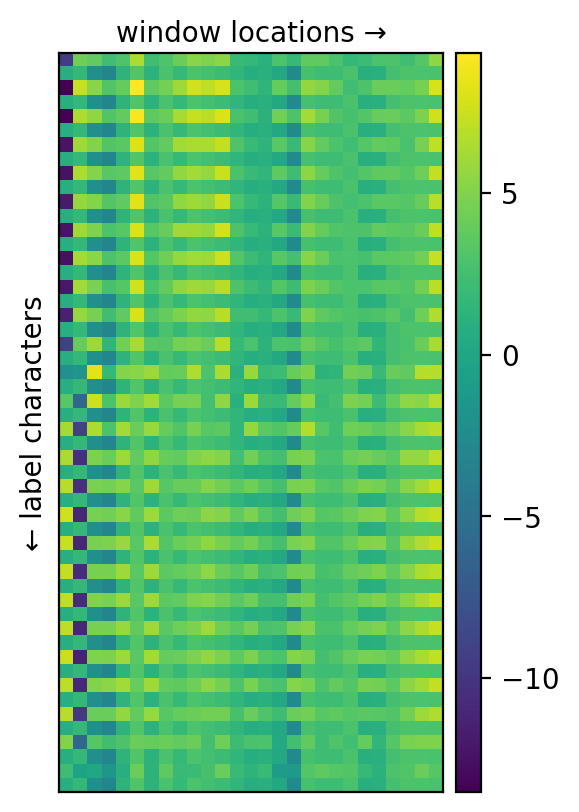

In [15]:
def plot_pm(pm, path=None):
    fig=plt.figure(dpi=200)
    ax = plt.axes()
    im = ax.imshow(pm.cpu().T)

    ax.set_xlabel('window locations →')
    ax.set_ylabel('← label characters')
    ax.xaxis.set_label_position('top')
    ax.set_xticks([])
    ax.set_yticks([])

    if path is not None:
        for i in range(len(path) - 1):
            ax.plot(*path[i], *path[i+1], marker = 'o', markersize=0.5, linewidth=10, color='r', alpha=1)

    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)

energies = model(alphabet.cuda().view(1, 1, *alphabet.shape)) # [1, k, 27]
targets = transform_word(string.ascii_lowercase).unsqueeze(0).cuda() # [1, 26 * 2]
print(string.ascii_lowercase)

pm = build_path_matrix(energies, targets)
plot_pm(pm[0].detach())

Now let's implement a function that would tell us the energy of a particular path (i.e. pairing).

In [ ]:
def path_energy(pm, path):
    # inputs:
    #   pm - a matrix of energies (L, T)
    #    L - energies length
    #    T - targets length
    #   path - list of length L tuples that maps each energy vector to an element in T
    # returns:
    #   energy - sum of energies on the path, or 2**30 if the mapping is invalid

    L, T = pm.shape

    # check to see if mapping is invalid .
    for i in range(L - 1):
        if  not (path[i] <= path[i + 1] <= path[i] + 1):
            return 2**30

    # sum energies
    tot_energy = pm[torch.arange(L), torch.tensor(path, dtype=torch.long, device=pm.device)].sum().item()
    return tot_energy


Now we can check some randomly generated paths and see the associated energies for our alphabet image:

energy is 63.6837158203125


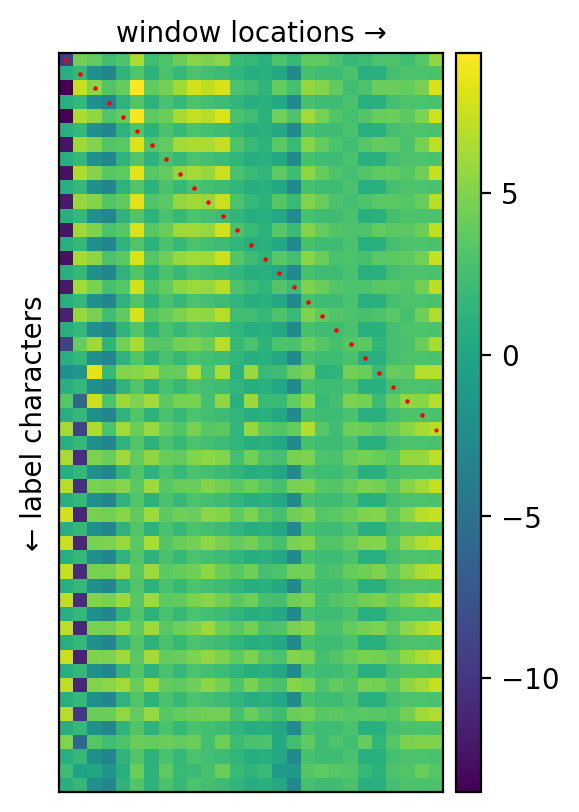

In [17]:
path = torch.zeros(energies.shape[1] - 1) # [L - 1]
path[:targets.shape[1] - 1] = 1
path = [0] + list(map(lambda x : x.int().item(), path[torch.randperm(path.shape[0])].cumsum(dim=-1)))
points = list(zip(range(energies.shape[1]), path))

plot_pm(pm[0].detach(), points)
print('energy is', path_energy(pm[0], path))

## Part - 1\: Viterbi

### Optimal path finding
Now, we're going to implement the finding of the optimal path. To do that, we're going to use Viterbi algorithm, which in this case is a simple dynamic programming problem.
In this context, it's a simple dynamic programming algorithm that for each pair i, j, calculates the minimum cost of the path that goes from 0-th index in the energies and 0-th index in the target, to i-th index in the energies, and j-th index in the target. We can memorize the values in a 2-dimensional array, let's call it `dp`. Then we have the following transitions:
```
dp[0, 0] = pm[0, 0]
dp[i, j] = min(dp[i - 1, j], dp[i - 1, j - 1]) + pm[i, j]
```

The optimal path can be recovered if we memorize which cell we came from for each `dp[i, j]`.



In [ ]:
def find_path(pm):
    # inputs:
    #   pm - a tensor of shape LxT with energies
    #     L is length of energies array
    #     T is target sequence length
    # NOTE: this is slow because it's not vectorized to work with batches.
    #  output:
    #     a tuple of three elements:
    #         1. sum of energies on the best path,
    #         2. list of tuples - points of the best path in the pm matrix
    #         3. the dp array

    L, T = pm.shape
    dp = torch.empty_like(pm)
    # storing the predecessor
    predecessor = [[None for _ in range(T)] for _ in range(L)]

    # initialize
    dp[0, 0] = pm[0, 0]
    predecessor[0][0] = None

    for i in range(1, L):
        dp[i, 0] = dp[i-1, 0] + pm[i, 0]
        predecessor[i][0] = (i-1, 0)

    # fill rest
    for i in range(1, L):
        for j in range(1, T):
            cost_stay = dp[i-1, j]
            cost_advance = dp[i-1, j-1]
            if cost_stay <= cost_advance:
                dp[i, j] = cost_stay + pm[i, j]
                predecessor[i][j] = (i-1, j)
            else:
                dp[i, j] = cost_advance + pm[i, j]
                predecessor[i][j] = (i-1, j-1)

    # optimal ends at l-1, t-1
    total_energy = dp[L-1, T-1].item()

    #backtrack
    path = []
    i, j = L - 1, T - 1
    while True:
        path.append((i, j))
        if predecessor[i][j] is None:
            break
        i, j = predecessor[i][j]
    path.reverse()  # rev path.

    return total_energy, path, dp


Let's take a look at the best path:

free energy is nan


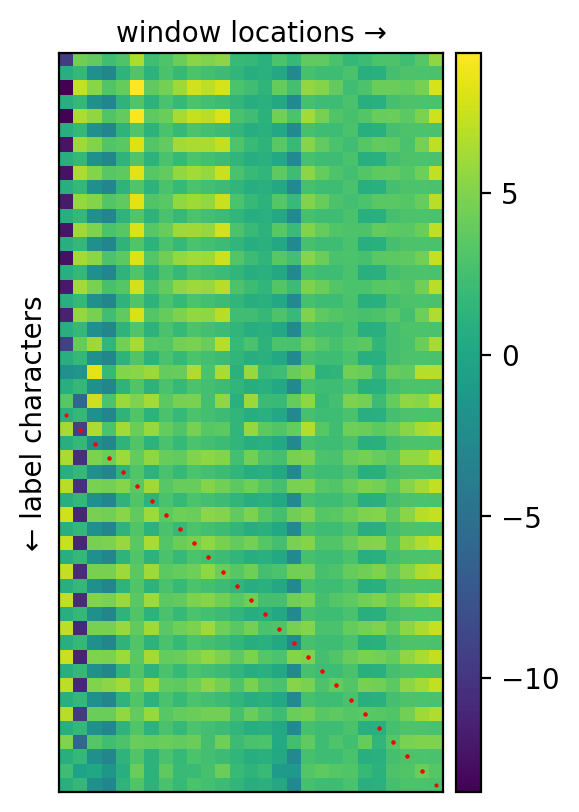

In [19]:
free_energy, path, d = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy)

(np.float64(-0.5), np.float64(26.5), np.float64(51.5), np.float64(-0.5))

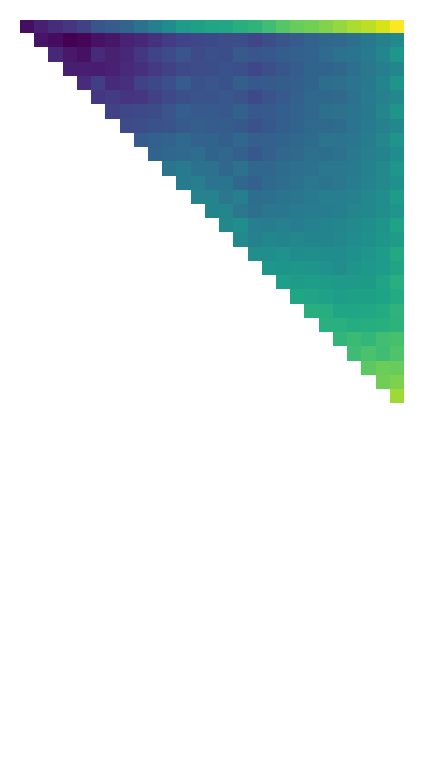

In [20]:
plt.figure(dpi=200)
plt.imshow(d.cpu().detach().T.clamp(-10000, 10000))
plt.axis('off')

### Training loop
Now is time to train the network using our best path finder. We're going to use the energy loss function:
$$\ell(x, y) = \sum_i H(y_{z(i)}, l_i)$$
Where $z$ is the best path we've found. This is akin to pushing down on the free energy $F(x, y)$, while pushing up everywhere else by nature of cross-entropy.

In [ ]:
def path_cross_entropy(ce, path):
    # to be used in train_ebm_model below
    # inputs:
    #   ce - a matrix of cross entropy
    #    L - energies length
    #    T - targets length
    #   path - list of length L tuples (l, t) that tracks the optimal path
    # returns:
    #   total cross entropy of best path

    idxs = torch.tensor(path, dtype=torch.long, device=ce.device)
    return ce[idxs[:, 0], idxs[:, 1]].sum()


In [22]:
def train_ebm_model(model, num_epochs, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    num_batches = 0

    # Use tqdm for a progress bar over epochs
    pbar = tqdm(range(num_epochs), desc="Training")

    for epoch in pbar:
        epoch_start = time.time()  # Record start time for the epoch
        epoch_loss = 0.0

        for images, targets in train_loader:
            images = images.cuda()  # [B, C, H, W]
            targets = targets.cuda()  # [B, T], T is target sequence length
            optimizer.zero_grad()
            energies = model(images).transpose(1, 2)  # [B, L, 27], L is window positions
            batch_loss = 0.0
            B = images.size(0)
            for b in range(B):
                samp_energy = energies[b].unsqueeze(0)  # [1, L, 27]
                samp_target = targets[b].unsqueeze(0)   # [1, T]
                ce = build_ce_matrix(samp_energy, samp_target)[0]  # [L, T]
                _, path, _ = find_path(ce)  # Find optimal alignment
                loss = criterion(ce, path)  # Compute loss along the path
                batch_loss += loss
            batch_loss /= B  # Average loss over batch
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item()
            num_batches += 1

        # Calculate epoch time
        epoch_time = time.time() - epoch_start
        avg_epoch_loss = epoch_loss / len(train_loader)

        # Update tqdm progress bar with loss and epoch time
        pbar.set_postfix({'loss': avg_epoch_loss, 'epoch_time': f"{epoch_time:.2f}s"})

        # Explicitly print epoch time and loss
        print(f"Epoch {epoch + 1}/{num_epochs} completed in {epoch_time:.2f} seconds, Average Loss: {avg_epoch_loss:.4f}")

        total_loss += avg_epoch_loss

    avg_loss = total_loss / num_epochs
    print(f"Training completed. Average Loss over {num_epochs} epochs: {avg_loss:.4f}")
    return avg_loss

In [ ]:
import copy
import time

def collate_fn(samples):
    """ A function to collate samples into batches for multi-character case"""
    images, annotations = zip(*samples)
    images = list(images)
    annotations = list(annotations)
    annotations = list(map(transform_word, annotations))
    m_width = max(18, max([i.shape[1] for i in images]))
    m_length = max(3, max([s.shape[0] for s in annotations]))
    for i in range(len(images)):
        images[i] = torch.nn.functional.pad(images[i], (0, m_width - images[i].shape[-1]))
        annotations[i] = torch.nn.functional.pad(annotations[i], (0, m_length - annotations[i].shape[0]), value=BETWEEN)
    if len(images) == 1:
        return images[0].unsqueeze(0).unsqueeze(0), torch.stack(annotations)
    else:
        return torch.stack([img.unsqueeze(0) for img in images]), torch.stack(annotations)

sds = SimpleWordsDataset(2, 2500) # for simplicity, we're training only on words of length two

BATCH_SIZE = 32
dataloader = torch.utils.data.DataLoader(sds, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn)

# 1. Create SimpleNet() model
#          To simplify the task, you can initialize the model with
#          the weights of single-character model. That would incur a 5 points
#          penalty though.
#       2. Initialize optimizer
#       3. Train the model

model = SimpleNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
avg_loss = train_ebm_model(model, num_epochs, dataloader, path_cross_entropy, optimizer)

print(f"Average training loss: {avg_loss}")



Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 completed in 34.12 seconds, Average Loss: 25.9374
Epoch 2/10 completed in 33.53 seconds, Average Loss: 1.7937
Epoch 3/10 completed in 33.39 seconds, Average Loss: 1.0420
Epoch 4/10 completed in 32.59 seconds, Average Loss: 0.8034
Epoch 5/10 completed in 33.46 seconds, Average Loss: 0.7067
Epoch 6/10 completed in 33.35 seconds, Average Loss: 0.7280
Epoch 7/10 completed in 33.32 seconds, Average Loss: 0.6998
Epoch 8/10 completed in 32.79 seconds, Average Loss: 0.6223
Epoch 9/10 completed in 33.27 seconds, Average Loss: 0.5891
Epoch 10/10 completed in 33.52 seconds, Average Loss: 0.6028
Training completed. Average Loss over 10 epochs: 3.3525
Average training loss: 3.3525086268405375


Let's check what the energy matrix looks like for the alphabet image now.

free energy is 42.81952667236328


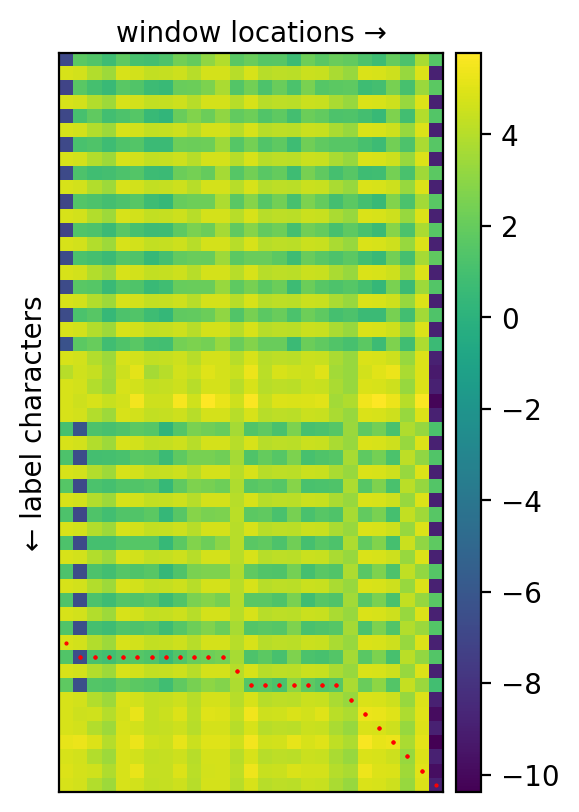

In [24]:
import torch.nn.functional as F
energies = model(alphabet.unsqueeze(0).unsqueeze(0).cuda())

targets = transform_word(string.ascii_lowercase).cuda()
pm = build_path_matrix(energies, targets.unsqueeze(0))

free_energy, path, _ = find_path(pm[0])
plot_pm(pm[0].detach(), path)
print('free energy is', free_energy)

**Free energy increased because we went from dealing with single letters to longer sequences and are summing cross-entropies over a greater number of positions**

We can also look at raw energies output:

(np.float64(-0.5), np.float64(26.5), np.float64(339.5), np.float64(-0.5))

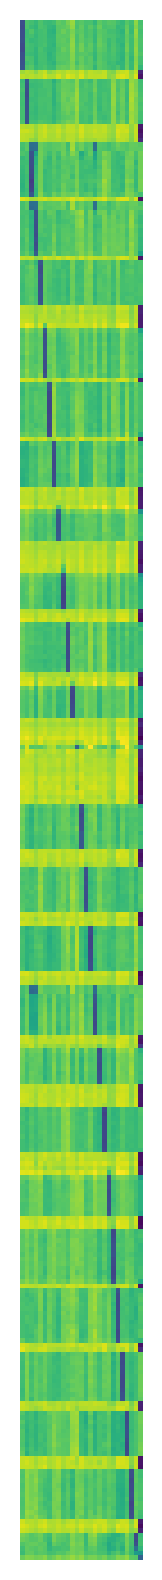

In [25]:
alphabet_energy_post_train_viterbi = model(alphabet.cuda().view(1, 1, *alphabet.shape))

plt.figure(dpi=200, figsize=(40, 10))
plt.imshow(alphabet_energy_post_train_viterbi.cpu().data[0].T)
plt.axis('off')

**The energies are much more higher and arent changing as much as the one one-character dataset i.e. the one character dataset had a bunch of changes in energy low to high to low whereas this one is just consistently high**

## Decoding

Now we can use the model for decoding a word from an image. Let's pick some word, apply the model to it, and see energies.

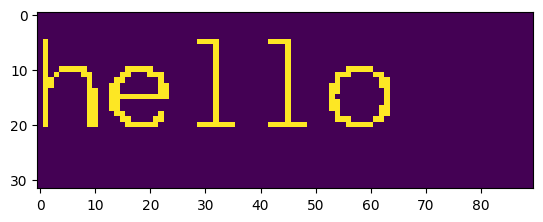

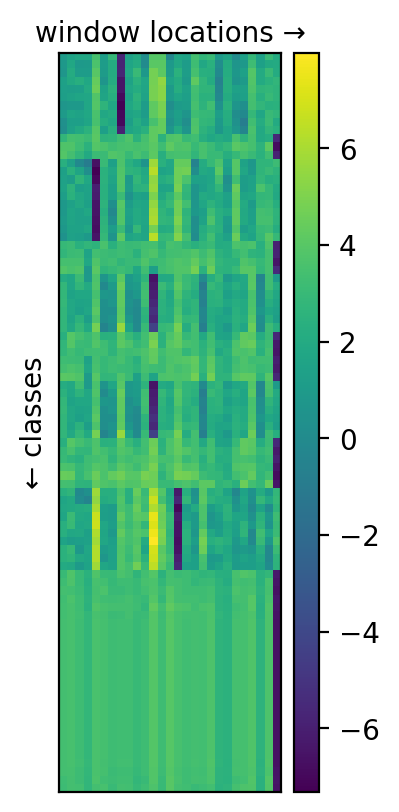

In [26]:
img = sds.draw_text('hello')
energies = model(img.cuda().unsqueeze(0).unsqueeze(0))
plt.imshow(img)
plot_energies(energies[0].detach().cpu())

In [ ]:
from collections import Counter

def idx_to_char(idx):
  if idx == 26:
    return '_'
  else:
    return chr(ord('a') + idx)

def indices_to_str(indices):
    """
    Decodes a sequence of indices into a string using the following steps:

      1. Iterate through the sequence of indices (a torch.Tensor).
      2. Use index 26 as a special divider:
         - For contiguous indices not equal to 26, compute the most common index and convert it to a character.
         - When a divider (26) is encountered, insert an underscore ('_') as a placeholder (only once for consecutive 26's).
      3. Finally, remove all underscores from the intermediate result.

    Example:
      For a predicted sequence corresponding to "aaab_bab_", the intermediate decoded result is "a_b"
      and the final output (after removing '_') is "ab".

    Args:
        indices (torch.Tensor): Tensor of predicted class indices.

    Returns:
        str: The decoded string.
    """
    # Convert tensor to list for easier iteration.
    indices = indices.tolist()
    decoded = []
    i = 0
    n = len(indices)

    while i < n:
        if indices[i] == 26:
            # add an underscore as a segment marker.
            if decoded and decoded[-1] != '_' and i < n - 1:
                decoded.append('_')
            # Skip all consecutive dividers.
            while i < n and indices[i] == 26:
                i += 1
        else:
            # Gather a contiguous segment of non-divisor indices.
            segment = []
            while i < n and indices[i] != 26:
                segment.append(indices[i])
                i += 1
            # compute the most common index.
            cnt = Counter(segment)
            most_common_idx, _ = cnt.most_common(1)[0]
            decoded.append(idx_to_char(most_common_idx))

    intermediate = ''.join(decoded)

    final_str = intermediate.replace('_', '')
    return final_str

probs = F.softmax(-energies[0], dim=0)

predicted_indices = probs.argmax(dim=0)
print(predicted_indices)
print(indices_to_str(predicted_indices))

tensor([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 26, 26, 26,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4, 26, 26, 26, 26, 11, 11, 11, 11, 11, 11, 11, 26, 26,
        26, 26, 26, 26, 11, 11, 11, 11, 11, 11, 11, 26, 26, 26, 26, 26, 26, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
       device='cuda:0')
hello
